# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

In [77]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math

In [78]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [79]:
# number of callbacks for white-sounding and black-sounding names
w_calls = sum(data[data.race=='w'].call)
b_calls = sum(data[data.race=='b'].call)
print('There were ', w_calls, 'call backs for white sounding names and ', b_calls, 'call backs for black sounding names.')

There were  235.0 call backs for white sounding names and  157.0 call backs for black sounding names.


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

## 1. What test is appropriate for this problem? Does CLT apply?

#### We are trying to test if race has a significant impact on the callback rate for resumes. With 4870 resumes, the CLT applies and states that the difference between the two proportions is approximately a normal distribution. For this, I will use a z test.

## 2. What are the null and alternate hypotheses?

#### The null hypothesis is that there is no difference in callback rates between races, the alternative is that there is a significant difference in callback rates.

## 3.Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

In [81]:
#Check how many actual call backs happened and out of how many resumes
w = data[data.race=='w']
b = data[data.race=='b']
print(len(w))
print(len(b))

data.groupby(['race','call']).size().unstack()

2435
2435


call,0.0,1.0
race,,
b,2278,157
w,2200,235


In [82]:
#Find all the sums
cb_b = sum(data.call[(data.race == 'b')])
cb_w = sum(data.call[(data.race == 'w')])
cb_t = sum(data.call)

#Calculate the rates
cb_rate_b = cb_b / cb_t
cb_rate_w = cb_w / cb_t

print('The call back rate for black sounding names:', cb_rate_b)
print('The call back rate for white sounding names:', cb_rate_w)

# compute mean of all
mean_t = np.mean(data.call)
mean_b = np.mean(data.call[(data.race == 'b')])
mean_w = np.mean(data.call[(data.race == 'w')])
print(mean_t,' is the total mean of callbacks')
print(mean_b,' is the mean of callbacks for black sounding names')
print(mean_w,' is the mean of callbacks for white sounding names')

The call back rate for black sounding names: 0.400510204082
The call back rate for white sounding names: 0.599489795918
0.08049281686544418  is the total mean of callbacks
0.0644763857126236  is the mean of callbacks for black sounding names
0.09650924056768417  is the mean of callbacks for white sounding names


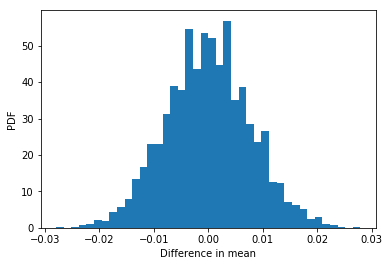

In [83]:
# Create arrays for black and white applicants
black = data.call[(data.race == 'b')]
white = data.call[(data.race == 'w')]

# Compute the difference of mean
empirical_diff_means = mean_b - mean_w

# Create shifted arrays
b_shifted = black - mean_b + mean_t
w_shifted = white - mean_w + mean_t

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

# Compute 10,000 bootstrap replicates from shifted array
bs_replicates_b = draw_bs_reps(b_shifted, np.mean, 10000)
bs_replicates_w = draw_bs_reps(w_shifted, np.mean, 10000)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=40, normed=True)
_ = plt.xlabel('Difference in mean')
_ = plt.ylabel('PDF')
plt.show()

In [84]:
# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_b - bs_replicates_w

# Compute and print p-value: p
p = np.sum(bs_replicates <= empirical_diff_means) / len(bs_replicates)
print('The p-value for the test of equality of callback rates is: ', p)

The p-value for the test of equality of callback rates is:  0.0003


In [85]:
# calculate margins of error for the two distributions
seb = math.sqrt((cb_rate_b*(1-cb_rate_b))/len(b)) 
sew = math.sqrt((cb_rate_w*(1-cb_rate_w))/len(w)) 
se_diff = math.sqrt(math.pow(seb,2) + math.pow(sew,2))

# calculate confidence interval for difference in the distributions
conf_int_lower = abs(cb_rate_b-cb_rate_w)-1.96*se_diff
conf_int_upper = abs(cb_rate_b-cb_rate_w)+1.96*se_diff
conf_int = [conf_int_lower,conf_int_upper]

print('confidence interval for the difference of black & white callback rate:')
print(conf_int)

confidence interval for the difference of black & white callback rate:
[0.17145510208788942, 0.22650408158558008]


## 4. Write a story describing the statistical significance in the context or the original problem. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

#### Using bootstrap replicates, we are able to say that if the true mean call back was the same for white and black call backs we would only get this sample result 3 times in 10,000 randomized samples. Our p-value was 0.0003, which is less than alpha of 0.05. This means we can reject the null hypothesis and conclude that there was a significant difference in call backs by race. 95% of the time the difference of the call back rates were between 0.1715 and 0.2265. 

#### While there is no way to conclude causation, there is evidence that race is strongly correlated to call back rate. There is also no way to say that it is the most important factor, but it does seem to be a factor. Every situation is different and with the data given we can only conclude so much. If I wanted to be even more sure of this difference in rates, I would include an analysis of years of experience, education level and more. 